# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import (
    Dense,
    Flatten,
    Dropout,
    Conv2D,
    MaxPooling2D,
    BatchNormalization,
)
# from keras.optimizers import SGD
from tensorflow.compat.v1.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Parameters for Model Training

In [2]:
batch_size = 32  # Number of samples per gradient update
num_classes = 10  # Total number of classes in the dataset
epochs = 100  # Number of epochs to train the model
data_augmentation = True  # Flag to determine whether to use data augmentation

# Load and Preprocess the CIFAR-10 Dataset

In [3]:
(train_x, train_y), (test_x, test_y) = cifar10.load_data()

170498071/170498071 [==============================] - 6s 0us/step


# Exploratory Data Analysis (EDA)

In [4]:
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

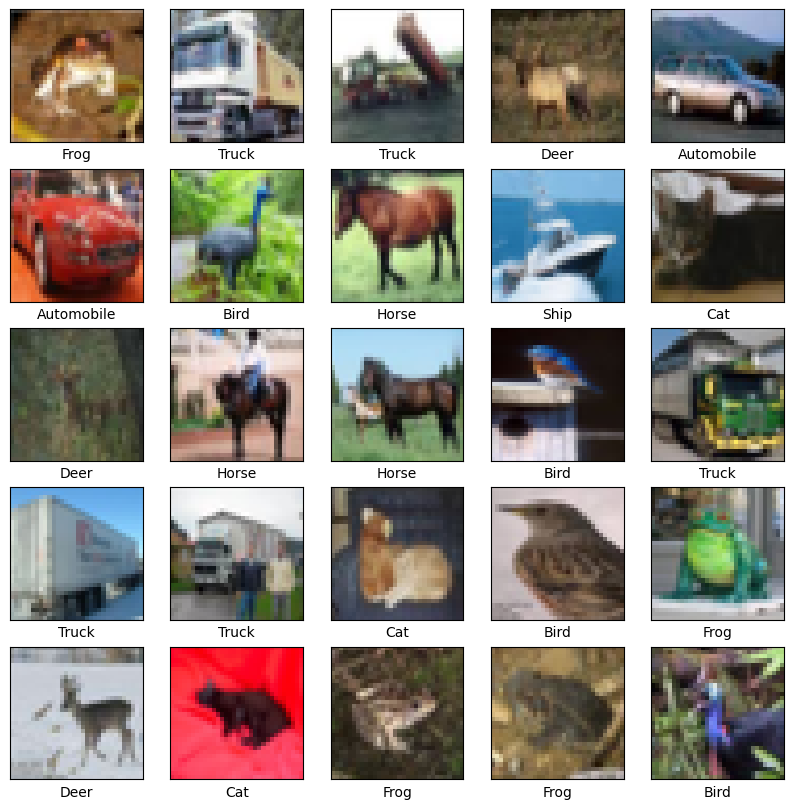

In [5]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_x[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_y[i][0]])
plt.show()

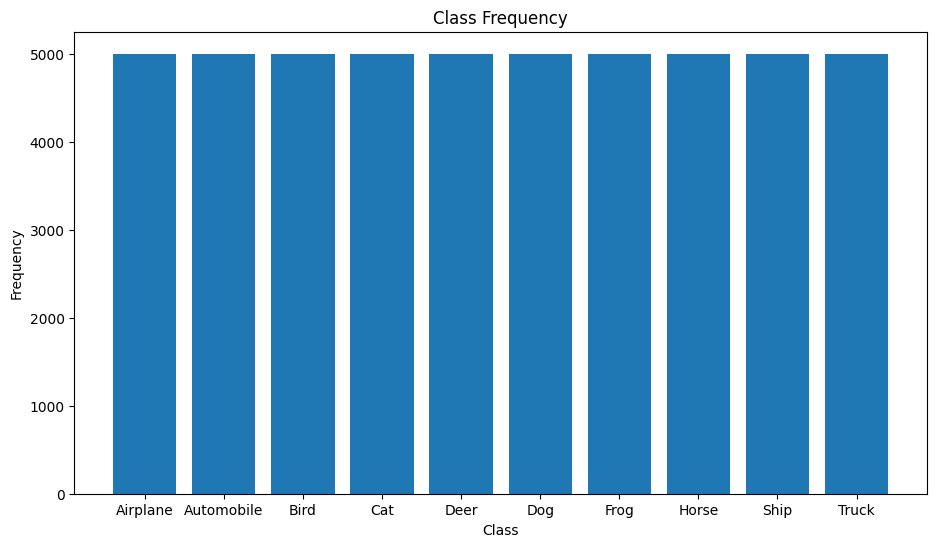

In [6]:
# Bar chart showing distribution of classes in training set
plt.figure(figsize=(11, 6))
unique, counts = np.unique(train_y, return_counts=True)

plt.bar(unique, counts)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(unique, class_names)
plt.show()

# Preprocess the Data with One-Hot Encoding

In [7]:
# Convert class vectors to binary class matrices
train_y = to_categorical(train_y, num_classes)
test_y = to_categorical(test_y, num_classes)

In [8]:
# Normalize pixel values to the range [0, 1]to aid in training convergence
train_x = train_x.astype("float32") / 255.0
test_x = test_x.astype("float32") / 255.0

# Define the CNN model

In [9]:
def define_model():
    model = Sequential()
    # First convolutional block with 32 filters, batch normalization, and dropout for regularization
    model.add(
        Conv2D(
            32,
            (3, 3),
            activation="relu",
            kernel_initializer="he_uniform",
            padding="same",
            input_shape=(32, 32, 3),
        )
    )
    model.add(BatchNormalization())
    model.add(
        Conv2D(
            32,
            (3, 3),
            activation="relu",
            kernel_initializer="he_uniform",
            padding="same",
        )
    )
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    # Second convolutional block with increased filter size for more complex feature extraction
    model.add(
        Conv2D(
            64,
            (3, 3),
            activation="relu",
            kernel_initializer="he_uniform",
            padding="same",
        )
    )
    model.add(BatchNormalization())
    model.add(
        Conv2D(
            64,
            (3, 3),
            activation="relu",
            kernel_initializer="he_uniform",
            padding="same",
        )
    )
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    # Flatten the output from the convolutional layers before passing to the dense layer
    model.add(Flatten())
    # Dense layer for classification
    model.add(Dense(128, activation="relu", kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    # Output layer with softmax activation for multi-class classification
    model.add(Dense(num_classes, activation="softmax"))

    # Compile the model with legacy SGD optimizer and categorical crossentropy loss function
    optimizer = SGD(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Instantiate and Compile the Model

In [10]:
model = define_model()

# Configure Data Augmentation

In [11]:
if data_augmentation:
    print("Using real-time data augmentation.")
    datagen = ImageDataGenerator(
        width_shift_range=0.1,  # Randomly shift images horizontally
        height_shift_range=0.1,  # Randomly shift images vertically
        horizontal_flip=True,  # Randomly flip images horizontally
    )
    # Compute quantities required for feature-wise normalization
    datagen.fit(train_x)

Using real-time data augmentation.


# Train the Model

In [12]:
if not data_augmentation:
    print("Not using data augmentation.")
    history = model.fit(
        train_x,
        train_y,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(test_x, test_y),
        shuffle=True,
    )
else:
    # Fit the model on the batches generated by datagen.flow()
    history = model.fit(
        datagen.flow(train_x, train_y, batch_size=batch_size),
        epochs=epochs,
        validation_data=(test_x, test_y),
        workers=4,
    )

Epoch 1/100
1563/1563 [==============================] - 49s 26ms/step - loss: 1.8519 - accuracy: 0.3658 - val_loss: 1.3617 - val_accuracy: 0.5025
Epoch 2/100
1563/1563 [==============================] - 43s 27ms/step - loss: 1.4522 - accuracy: 0.4760 - val_loss: 1.2365 - val_accuracy: 0.5580
Epoch 3/100
1563/1563 [==============================] - 40s 26ms/step - loss: 1.3345 - accuracy: 0.5225 - val_loss: 1.2172 - val_accuracy: 0.5587
Epoch 4/100
1563/1563 [==============================] - 44s 28ms/step - loss: 1.2388 - accuracy: 0.5580 - val_loss: 1.0745 - val_accuracy: 0.6165
Epoch 5/100
1563/1563 [==============================] - 43s 27ms/step - loss: 1.1794 - accuracy: 0.5811 - val_loss: 1.1172 - val_accuracy: 0.6029
Epoch 6/100
1563/1563 [==============================] - 40s 25ms/step - loss: 1.1255 - accuracy: 0.6011 - val_loss: 0.9442 - val_accuracy: 0.6630
Epoch 7/100
1563/1563 [==============================] - 40s 25ms/step - loss: 1.0908 - accuracy: 0.6159 - val_loss: 0

# Evaluate the Model's Performance on the Test Set

In [13]:
scores = model.evaluate(test_x, test_y, verbose=1)
print("Test loss:", scores[0])
print("Test accuracy:", scores[1])

313/313 [==============================] - 1s 4ms/step - loss: 0.5094 - accuracy: 0.8261
Test loss: 0.5093774795532227
Test accuracy: 0.8260999917984009


# Generate Predictions for Test Set

In [14]:
predictions = model.predict(test_x)

313/313 [==============================] - 1s 2ms/step


# Generate a Confusion Matrix and Classification Report to Evaluate the Model's Performance

In [15]:
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_y, axis=1)
cm = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix")
print(cm)
print("Classification Report")
print(classification_report(true_classes, predicted_classes, target_names=class_names))

Confusion Matrix
[[855  22  23   2   8   0   5   6  59  20]
 [  7 945   0   0   2   0   2   0   4  40]
 [ 54   3 705  15  66  25  89  26   6  11]
 [ 16   9  43 548  71 116 119  33  20  25]
 [ 11   1  29   8 837   7  68  29   7   3]
 [ 11   2  35  75  45 712  55  48   6  11]
 [  6   1  17   9  12   3 945   0   4   3]
 [ 15   4  19   9  40   7  16 874   3  13]
 [ 35  20   3   0   2   2   4   0 915  19]
 [ 12  48   4   2   1   0   1   0   7 925]]
Classification Report
              precision    recall  f1-score   support

    Airplane       0.84      0.85      0.85      1000
  Automobile       0.90      0.94      0.92      1000
        Bird       0.80      0.70      0.75      1000
         Cat       0.82      0.55      0.66      1000
        Deer       0.77      0.84      0.80      1000
         Dog       0.82      0.71      0.76      1000
        Frog       0.72      0.94      0.82      1000
       Horse       0.86      0.87      0.87      1000
        Ship       0.89      0.92      0.90

# Plot Training and Validation Accuracy and Loss to Visualize the Model's Learning Over Time

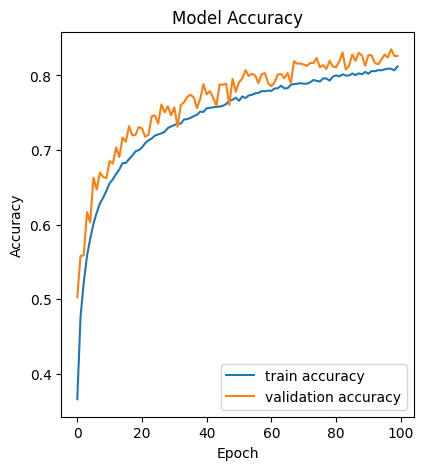

In [16]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="validation accuracy")
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()

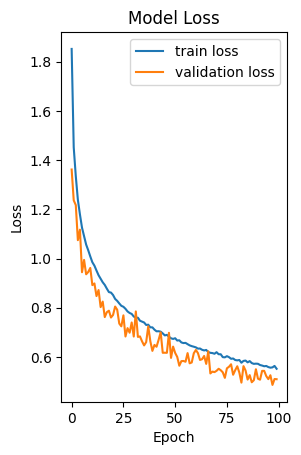

In [17]:
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()